In [5]:
import torch
import timm
import numpy as np
from transformers import AutoModelForImageClassification, AutoImageProcessor
from torchsummary import summary
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if CUDA is set up correctly
print(torch.backends.cudnn.version())  # Should print cuDNN version (e.g., 8906 for 8.9.6)

2.5.0+cu118
True
90100


In [13]:
# load the pre-trained Swin Transformer V2 model and modify the output layer
model = timm.create_model('swinv2_base_window8_256', pretrained=True)
model.head.fc = nn.Linear(1024, 4, bias=True)

In [14]:
# Freeze all layers except the final classification head
for param in model.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if 'head' not in name:
        param.requires_grad=False

In [16]:
# get the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train
# Create the dataset from a folder containing images
dataset = datasets.ImageFolder(root='../data/cropped_images/', transform=transform)

# Create a DataLoader to load images in batches
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Test
# Create the dataset from a folder containing images
dataset_test = datasets.ImageFolder(root='../data/cropped_images_test/', transform=transform)

# Create a DataLoader to load images in batches
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True, num_workers=4)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)  # Will print 'cuda' if GPU is available, else 'cpu'

model= model.to(device)

cuda


In [18]:
# Define the optimizer and loss function, focusing only on the parameters of the head
optimizer = torch.optim.Adam(model.head.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs=50

train_result=[]
test_result=[]
test_accuracy=[]
# Training loop
for epoch in range(num_epochs):

    train_loss, train_accuracy=0, 0
    count=0
    for images, labels in tqdm(dataloader):
        count+=1
        x, y = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(x)
        

        loss = criterion(outputs, y)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        #print(y)
        #print('train ', epoch , ' loss and accuracy', loss, (predicted==y).sum().item()/predicted.size(0))
        #training_result[epoch].append([loss, predicted==y])
        train_loss += loss
        train_accuracy += (predicted==y).sum().item()/predicted.size(0)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= count
    train_accuracy /= count
    print('epoch ', epoch, '\nTrain loss :', train_loss.item(), ' - Train accuracy:', train_accuracy)
    train_result.append([train_loss, train_accuracy])
    # Assuming 'test_loader' is your DataLoader for the test dataset
    correct = 0
    total = 0
    
    # Put model in evaluation mode
    model.eval()

    #test_result.append([])

    test_loss=0
    test_count=0
    # Disable gradient computation
    with torch.no_grad():
        for images, labels in dataloader_test:
            test_count+=1
            x, y = images.to(device), labels.to(device)  # Move data to GPU if available
    
            # Forward pass
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class with highest score

            test_loss+= criterion(outputs, y)
            #test_result[epoch].append([criterion(outputs, y) , predicted==y])
            # Count the correct predictions
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    # Calculate accuracy
    #accuracy = 100 * correct / total
    accuracy =  correct / total
    test_result.append([test_loss/test_count, accuracy])
    test_accuracy.append(accuracy)
    print('Test Loss ', (test_loss/test_count).item(), ' - Test Accuracy :', accuracy)
    #print(f'Test Accuracy: {accuracy:.2f}%')

  0%|          | 0/179 [00:00<?, ?it/s]

epoch  0 
Train loss : 1.0920144319534302  - Train accuracy: 0.5161612130885874
Test Loss  1.0231614112854004  - Test Accuracy : 0.5355450236966824


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  1 
Train loss : 0.9785546660423279  - Train accuracy: 0.5769154030327215
Test Loss  0.9672393798828125  - Test Accuracy : 0.5781990521327014


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  2 
Train loss : 0.9348246455192566  - Train accuracy: 0.6013567438148444
Test Loss  0.952968418598175  - Test Accuracy : 0.5908372827804107


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  3 
Train loss : 0.9065233469009399  - Train accuracy: 0.6179918196328811
Test Loss  0.9323881268501282  - Test Accuracy : 0.593996840442338


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  4 
Train loss : 0.8806061148643494  - Train accuracy: 0.63268156424581
Test Loss  0.9337124824523926  - Test Accuracy : 0.5987361769352291


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  5 
Train loss : 0.864097535610199  - Train accuracy: 0.639914205905826
Test Loss  0.9192075729370117  - Test Accuracy : 0.608214849921011


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  6 
Train loss : 0.8494697213172913  - Train accuracy: 0.6470969672785315
Test Loss  0.9106213450431824  - Test Accuracy : 0.6129541864139021


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  7 
Train loss : 0.8327970504760742  - Train accuracy: 0.6581953312051078
Test Loss  0.9309725165367126  - Test Accuracy : 0.6050552922590837


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  8 
Train loss : 0.821060061454773  - Train accuracy: 0.6684956105347167
Test Loss  0.9300811886787415  - Test Accuracy : 0.6161137440758294


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  9 
Train loss : 0.8102469444274902  - Train accuracy: 0.6730097765363129
Test Loss  0.9150673747062683  - Test Accuracy : 0.6145339652448657


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  10 
Train loss : 0.8027957081794739  - Train accuracy: 0.674007382282522
Test Loss  0.9104061126708984  - Test Accuracy : 0.6255924170616114


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  11 
Train loss : 0.79200279712677  - Train accuracy: 0.680591580207502
Test Loss  0.9022216796875  - Test Accuracy : 0.6192733017377567


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  12 
Train loss : 0.783763587474823  - Train accuracy: 0.6896697924980049
Test Loss  0.9067330360412598  - Test Accuracy : 0.608214849921011


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  13 
Train loss : 0.776930570602417  - Train accuracy: 0.6898194333599361
Test Loss  0.9163915514945984  - Test Accuracy : 0.6145339652448657


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  14 
Train loss : 0.7739455103874207  - Train accuracy: 0.6932112928970471
Test Loss  0.9033600091934204  - Test Accuracy : 0.6287519747235387


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  15 
Train loss : 0.764683723449707  - Train accuracy: 0.6991969273743017
Test Loss  0.909575879573822  - Test Accuracy : 0.627172195892575


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  16 
Train loss : 0.7582386136054993  - Train accuracy: 0.696054469273743
Test Loss  0.8885087370872498  - Test Accuracy : 0.6334913112164297


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  17 
Train loss : 0.7502761483192444  - Train accuracy: 0.7045590582601756
Test Loss  0.8799015283584595  - Test Accuracy : 0.6398104265402843


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  18 
Train loss : 0.7435743808746338  - Train accuracy: 0.699670790103751
Test Loss  0.9052435755729675  - Test Accuracy : 0.641390205371248


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  19 
Train loss : 0.7440584897994995  - Train accuracy: 0.7010674381484437
Test Loss  0.890194833278656  - Test Accuracy : 0.6334913112164297


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  20 
Train loss : 0.7377319931983948  - Train accuracy: 0.7070780127693536
Test Loss  0.8904142379760742  - Test Accuracy : 0.627172195892575


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  21 
Train loss : 0.7317304611206055  - Train accuracy: 0.7086991221069434
Test Loss  0.8981882929801941  - Test Accuracy : 0.6429699842022117


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  22 
Train loss : 0.7275519371032715  - Train accuracy: 0.7122655626496408
Test Loss  0.8999085426330566  - Test Accuracy : 0.6350710900473934


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  23 
Train loss : 0.7270315885543823  - Train accuracy: 0.7143355945730248
Test Loss  0.8839103579521179  - Test Accuracy : 0.636650868878357


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  24 
Train loss : 0.7204033732414246  - Train accuracy: 0.7162559856344772
Test Loss  0.8882727026939392  - Test Accuracy : 0.6429699842022117


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  25 
Train loss : 0.7142801284790039  - Train accuracy: 0.7166051476456504
Test Loss  0.9095827341079712  - Test Accuracy : 0.6240126382306477


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  26 
Train loss : 0.7126774191856384  - Train accuracy: 0.7152833200319233
Test Loss  0.89080411195755  - Test Accuracy : 0.641390205371248


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  27 
Train loss : 0.7088172435760498  - Train accuracy: 0.7196229050279329
Test Loss  0.8844024538993835  - Test Accuracy : 0.641390205371248


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  28 
Train loss : 0.7073160409927368  - Train accuracy: 0.7236632083000798
Test Loss  0.8893996477127075  - Test Accuracy : 0.6398104265402843


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  29 
Train loss : 0.7022392153739929  - Train accuracy: 0.7201965283320032
Test Loss  0.8967226147651672  - Test Accuracy : 0.6398104265402843


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  30 
Train loss : 0.6965904831886292  - Train accuracy: 0.7295989624900239
Test Loss  0.8888694643974304  - Test Accuracy : 0.655608214849921


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  31 
Train loss : 0.6956024169921875  - Train accuracy: 0.7230895849960096
Test Loss  0.8714194297790527  - Test Accuracy : 0.65086887835703


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  32 
Train loss : 0.6994777917861938  - Train accuracy: 0.7259078212290503
Test Loss  0.8935320973396301  - Test Accuracy : 0.6492890995260664


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  33 
Train loss : 0.6882726550102234  - Train accuracy: 0.7274291699920191
Test Loss  0.9172849655151367  - Test Accuracy : 0.6287519747235387


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  34 
Train loss : 0.6909657716751099  - Train accuracy: 0.7245610534716681
Test Loss  0.9028390049934387  - Test Accuracy : 0.65086887835703


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  35 
Train loss : 0.6899215579032898  - Train accuracy: 0.7251346767757382
Test Loss  0.8878456950187683  - Test Accuracy : 0.6492890995260664


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  36 
Train loss : 0.6802659630775452  - Train accuracy: 0.7345121707901038
Test Loss  0.8810990452766418  - Test Accuracy : 0.6587677725118484


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  37 
Train loss : 0.6788359880447388  - Train accuracy: 0.7322675578611333
Test Loss  0.8892593383789062  - Test Accuracy : 0.6429699842022117


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  38 
Train loss : 0.6786144971847534  - Train accuracy: 0.7353102553870711
Test Loss  0.895765483379364  - Test Accuracy : 0.641390205371248


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  39 
Train loss : 0.6773146390914917  - Train accuracy: 0.7312948922585795
Test Loss  0.9072079658508301  - Test Accuracy : 0.6477093206951027


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  40 
Train loss : 0.6709825396537781  - Train accuracy: 0.736731843575419
Test Loss  0.8936082124710083  - Test Accuracy : 0.6477093206951027


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  41 
Train loss : 0.6721505522727966  - Train accuracy: 0.7334397446129289
Test Loss  0.8815178275108337  - Test Accuracy : 0.65086887835703


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  42 
Train loss : 0.6685985326766968  - Train accuracy: 0.7403731045490822
Test Loss  0.8879038095474243  - Test Accuracy : 0.6571879936808847


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  43 
Train loss : 0.6688219904899597  - Train accuracy: 0.7344622905027933
Test Loss  0.8967912793159485  - Test Accuracy : 0.641390205371248


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  44 
Train loss : 0.6652624011039734  - Train accuracy: 0.7371059457302473
Test Loss  0.8869683146476746  - Test Accuracy : 0.6461295418641391


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  45 
Train loss : 0.659450352191925  - Train accuracy: 0.7411961292897047
Test Loss  0.888430118560791  - Test Accuracy : 0.65086887835703


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  46 
Train loss : 0.6634718775749207  - Train accuracy: 0.739375498802873
Test Loss  0.8937387466430664  - Test Accuracy : 0.6445497630331753


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  47 
Train loss : 0.6566397547721863  - Train accuracy: 0.7443884676775738
Test Loss  0.8928661346435547  - Test Accuracy : 0.6477093206951027


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  48 
Train loss : 0.6565020680427551  - Train accuracy: 0.738702114924182
Test Loss  0.8951844573020935  - Test Accuracy : 0.660347551342812


  0%|          | 0/179 [00:00<?, ?it/s]

epoch  49 
Train loss : 0.6538386940956116  - Train accuracy: 0.7468326017557861
Test Loss  0.9083933234214783  - Test Accuracy : 0.6540284360189573


In [22]:
# get the result and plot
train_result_save=[]
for i in range(len(train_result)):
    aa=train_result[i]
    train_result_save.append( [aa[0].item(), aa[1]] )

test_result_save=[]
for i in range(len(test_result)):
    bb=test_result[i]
    test_result_save.append( [bb[0].item(), bb[1]] )

In [25]:
np.save('train_result', train_result_save)
np.save('test_result', test_result_save)

In [31]:
torch.save(model, 'torch_vit_model')

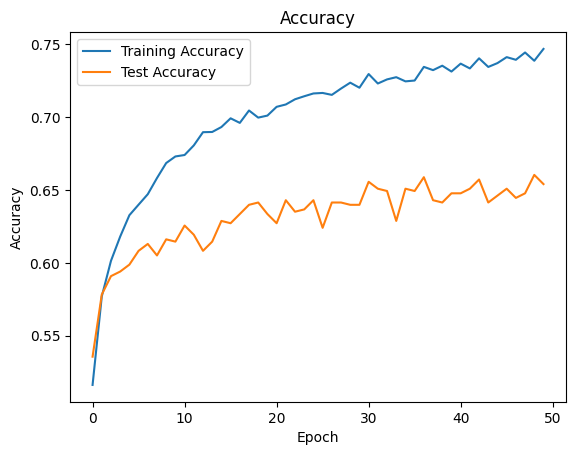

In [13]:
epochs = np.arange(50)

# accuracy plot
plt.plot(epochs, train_txt[:,1])
plt.plot(epochs, test_txt[:,1])
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

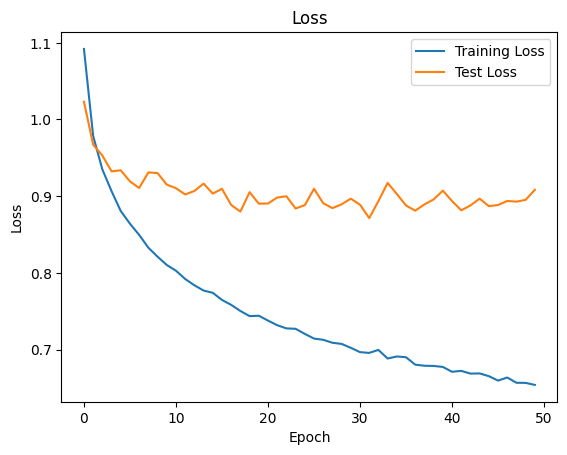

In [14]:
# loss plot
plt.plot(epochs, train_txt[:,0])
plt.plot(epochs, test_txt[:,0])
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()